In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os 

os.chdir('../') # Run once initially 


---

### Load and explore data


In [4]:
data = pd.read_csv(f"{os.getcwd()}/data/external/dataset.csv")

In [5]:
data.shape
print(f"First date:{data.date_created.min()} \nLast date:{data.date_created.max()}")

(4999, 9)

First date: "2019-10-17 07:32:54" 
Last date: "2019-12-16 09:07:15"


The data describes users' reading behaviours with each reading observation defined by nine features. There are 4999 observations collected over 60 days between October 17, 2019 and December 16, 2019. 

Let's take a look at a sample:

In [6]:
data.head(5)

,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book
0,-2147277864,1,"""2019-10-27 08:58:15""",chapter-8,bhargava,888,440,610,1
1,-2146355313,8,"""2019-12-14 10:05:50""",chapter-8,fain3,737,225,1069,1
2,-2146355313,8,"""2019-12-14 10:05:50""",chapter-1,ramamurthy,715,202,1120,1
3,-2146355313,8,"""2019-12-14 10:05:50""",chapter-1,thomas,445,136,816,1
4,-2146168866,2,"""2019-11-27 05:09:29""",about-this-book,prasanna,21,14,273,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                4999 non-null   int64 
 1   number_of_ticks        4999 non-null   int64 
 2   date_created           4999 non-null   object
 3   chapter                4999 non-null   object
 4   book                   4999 non-null   object
 5   numberofentriesofbook  4999 non-null   int64 
 6   numberofusersofbook    4999 non-null   int64 
 7   product_manning_id     4999 non-null   int64 
 8   user_owns_book         4999 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 351.6+ KB



Fortunately, there are no missing values in this dataset. However, there are some issues that need to be addressed in the data preparation step before we can create the edge list required to build the network diagram:

- Two issues stand out in `user_id`:
    - The values are strangely negative. In the data preparation step, this column will be standardized to positive integers.
    - Secondly, although `user_id` values are objects and not int64 data types, this aspect will be preserved because we need to sort the data using this column later. By sorting the data by `user_id` and `date_created`, we will mimic SQL partitioning. This will allow us to extract the edge list.
- Values in `date_created` are enquoted and objects; they need to be stripped before being converted to datetime64 types.

Next, we will explore the data further by answering the following questions:

1. How many users are big readers?
2. Which book is owned by the most?
3. Which book is read for the longest in each session?
4. How many readers own the books they read?


---

**2. Which book is owned by the most?**



---

**3. Which book is read for the longest in each session?**



---

**4. How many readers purchase the books they read?**



---

**1. Which users read the most? The least?**


In [216]:
user_id_counts = data["user_id"].value_counts()
user_id_counts = user_id_counts.to_frame()
user_id_counts.reset_index(inplace=True)
user_id_counts.rename(columns={"index":"user_id", "user_id":"count"}, inplace=True)

In [209]:
user_id_counts["user_id"] = user_id_counts["user_id"].apply(str)

In [214]:
user_id_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  641 non-null    object
 1   count    641 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [217]:
# y = user_id, x = count
y_pos = np.arange(len(user_id_counts.user_id))
ax.barh(y_pos, user_id_counts.count, align='center')
plt.show()

ConversionError: Failed to convert value(s) to axis units: [<bound method DataFrame.count of         user_id  count
0   -2021139802    653
1   -2088445927    331
2   -2074479722    106
3   -2135041721    104
4   -2074434789     89
..          ...    ...
636 -2054614214      1
637 -2053648004      1
638 -2114289612      1
639 -2053262764      1
640 -2147277864      1

[641 rows x 2 columns]>]

Users -2021139802 and -2088445927 account for 13.1 percent (653/4999) and 6.6 percent of the total reading activity respectively.


---

**2. How long are users' reading sessions?**


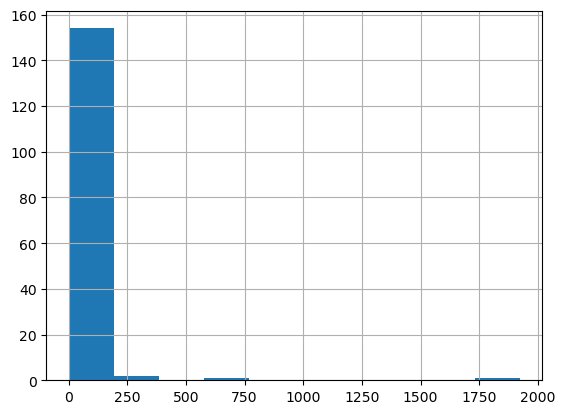

In [224]:
time_reading = data["number_of_ticks"].value_counts()
time_reading.hist(bins=10);

<Axes: ylabel='Density'>

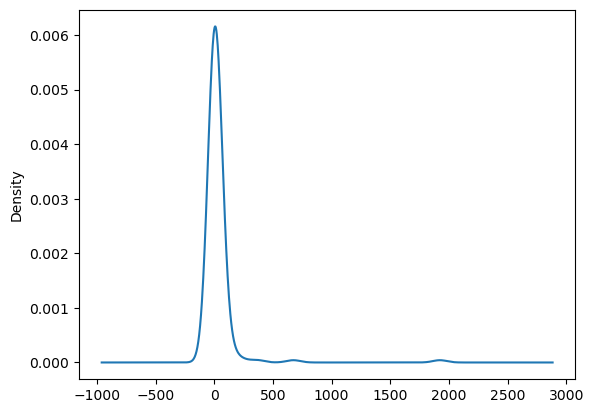

In [225]:
time_reading.plot.kde()

In [230]:
time_reading.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,
            ...
            227, 295, 221,  83, 279, 359,  94, 157, 120,  98],
           dtype='int64', length=158)

In [23]:
data["user_owns_book"].value_counts()

1    2875
0    2124
Name: user_owns_book, dtype: int64

In [24]:
data["book"].value_counts()

windmill      162
elgendy       134
skeet5        103
mcnamara       99
chollet        91
             ... 
black2          1
rosenberg       1
rosenbaum2      1
jones           1
wagner          1
Name: book, Length: 334, dtype: int64

In [231]:
data.groupby("book").count()

,user_id,number_of_ticks,date_created,chapter,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book
book,,,,,,,,
abernethy2,7,7,7,7,7,7,7,7
abraham,5,5,5,5,5,5,5,5
adzic,12,12,12,12,12,12,12,12
alag,4,4,4,4,4,4,4,4
allaire,56,56,56,56,56,56,56,56
...,...,...,...,...,...,...,...,...
zai,26,26,26,26,26,26,26,26
zburivsky,34,34,34,34,34,34,34,34
zumel,5,5,5,5,5,5,5,5



---

### Prepare data


In [8]:
# Transform features
data["date_created"] = data["date_created"].str.replace('"', '')
data["date_created"] = data["date_created"].str.strip()
data["date_created"] = pd.to_datetime(data["date_created"], format="%Y-%m-%d %H:%M:%S")

data["chapter"] = data["chapter"].str.strip()

data["user_id"] = data["user_id"].abs()

Note that user_id remains an int64 data type because we will be sorting it later (mathematical operation)

In [9]:
# "Partition" data by user and sort each user's entries chronologically
data = data.sort_values(by=["user_id", "date_created"])


---

### Create edge list

In [10]:
# Feature engineering for network diagram edge list
data["source"] =data["book"] # ADD CHAPTER, NOTE DIRECTED
data["target"]= data["source"].shift(-1)  
data["target_user_id"]= data["user_id"].shift(-1) # Store next row/target's `user_id` to verify that user reading behaviour is examined individually

In [11]:
# Mark and drop invalid rows
data["is_match"] = np.where((data["target_user_id"] == data["user_id"]), data["user_id"], np.nan)
data.dropna(subset=["is_match"], inplace=True)

In [12]:
# Verify edge list results before visualization
data

,user_id,number_of_ticks,date_created,chapter,book,numberofentriesofbook,numberofusersofbook,product_manning_id,user_owns_book,source,target,target_user_id,is_match
4997,2019295583,5,2019-11-12 13:47:10,chapter-7,urma2,2210,500,786,1,urma2,sholmes2,2.019296e+09,2.019296e+09
4979,2019295583,2,2019-11-26 07:39:39,chapter-3,sholmes2,705,148,901,0,sholmes2,sholmes2,2.019296e+09,2.019296e+09
4980,2019295583,2,2019-11-26 07:40:39,chapter-3,sholmes2,705,148,901,0,sholmes2,urma2,2.019296e+09,2.019296e+09
4995,2019295583,3,2019-11-26 07:44:44,chapter-1,urma2,2210,500,786,1,urma2,urma2,2.019296e+09,2.019296e+09
4996,2019295583,2,2019-11-26 07:46:14,chapter-1,urma2,2210,500,786,1,urma2,rodger,2.019296e+09,2.019296e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2145886989,4,2019-12-15 22:51:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
43,2145886989,8,2019-12-15 22:53:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
44,2145886989,48,2019-12-15 22:57:01,chapter-6,mcnamara,2533,461,880,1,mcnamara,mcnamara,2.145887e+09,2.145887e+09
1,2146355313,8,2019-12-14 10:05:50,chapter-8,fain3,737,225,1069,1,fain3,ramamurthy,2.146355e+09,2.146355e+09



---

### Visualize network diagram

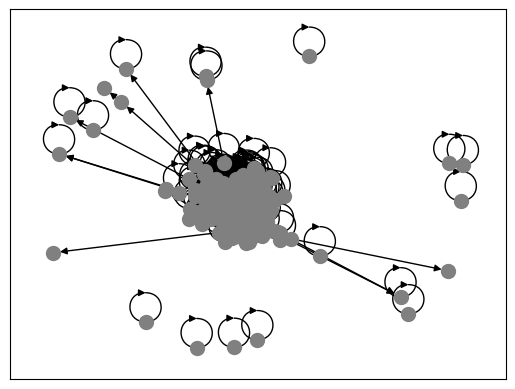

In [13]:
G = nx.from_pandas_edgelist(data,"source",'target', create_using=nx.DiGraph)
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="gray")


---

### Export data

In [16]:
data.to_csv("data/internal/edge_list.csv")